<a href="https://colab.research.google.com/github/Sanju30cp/week1/blob/main/garbage_classifiction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
import os

# Upload your kaggle.json file
uploaded = files.upload()  # Click "Choose File" and select kaggle.json

# Move the file to the correct directory and set permissions
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Verify the file is in place
!ls ~/.kaggle

Saving kaggle.json to kaggle.json
kaggle.json


In [ ]:
# Download the TrashNet dataset
!kaggle datasets download -d asdasdasasdas/garbage-classification

# Unzip the dataset (automatically creates a folder named 'Garbage classification')
!unzip -q garbage-classification.zip -d trashnet_dataset

# Verify the extracted files
!ls trashnet_dataset

Dataset URL: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
License(s): copyright-authors
 49% 40.0M/82.0M [00:00<00:00, 417MB/s]
100% 82.0M/82.0M [00:00<00:00, 520MB/s]
'garbage classification'	       one-indexed-files-notrash_val.txt
'Garbage classification'	       one-indexed-files.txt
 one-indexed-files-notrash_test.txt    zero-indexed-files.txt
 one-indexed-files-notrash_train.txt


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset path (adjust if needed)
dataset_dir = "/content/trashnet_dataset/garbage classification" # Changed to lowercase 'g'
image_size = (124, 124)
batch_size = 32
seed = 42

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% train, 20% validation
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=seed
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=seed
)

# Print class indices
print("Class indices:", train_generator.class_indices)

Found 2022 images belonging to 1 classes.
Found 505 images belonging to 1 classes.
Class indices: {'Garbage classification': 0}


In [ ]:
dataset_dir = "/content/trashnet_dataset/garbage classification" # Changed to lowercase 'g'
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2527 files belonging to 1 classes.
Using 2022 files for training.


In [ ]:
dataset_dir = "/content/trashnet_dataset/garbage classification" # Changed to lowercase 'g'
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names

Found 2527 files belonging to 1 classes.
Using 505 files for validation.


In [ ]:
# Get the total number of batches in the initial validation dataset (20% of total)
initial_val_batches = tf.data.experimental.cardinality(val_ds)

# Split the initial validation dataset into two equal parts:
# First half becomes the new validation dataset
val_ds_new = val_ds.take(initial_val_batches // 2)

# Second half becomes the test dataset
test_ds = val_ds.skip(initial_val_batches // 2)

# Update val_ds to the new validation dataset
val_ds = val_ds_new

# Optimize validation and test datasets by caching and prefetching
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

# The variable test_ds_eval is no longer needed as test_ds is now prefetched
# test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['Garbage classification']
['Garbage classification']
1


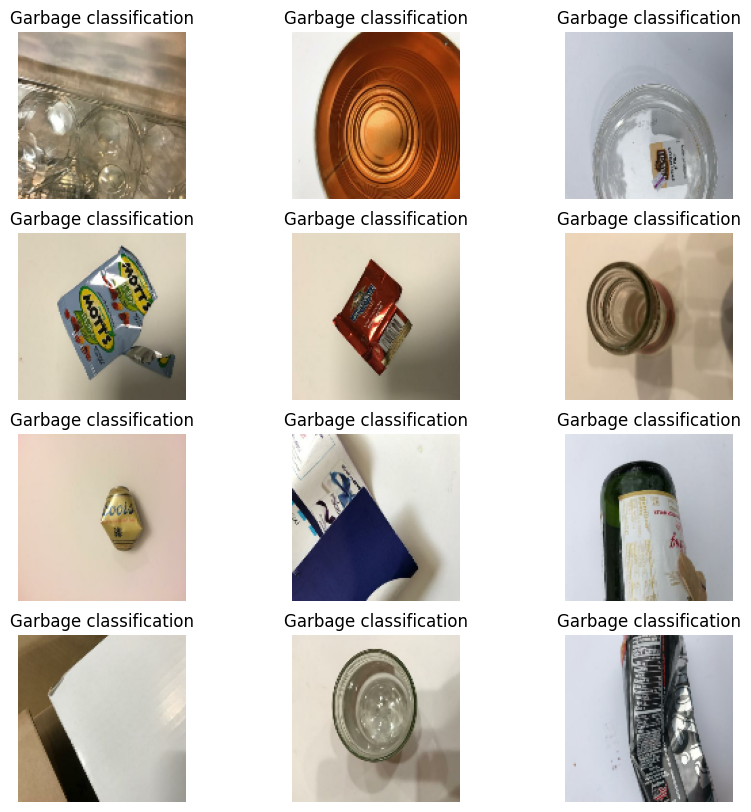

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [ ]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts

In [ ]:
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [ ]:
class_names = train_ds.class_names

# Helper to count class distribution in dataset
def get_distribution(dataset, class_names):
    counts = {k: 0 for k in class_names}
    total = 0
    for images, labels in dataset:
        for label in labels:
            class_name = class_names[int(label)]
            counts[class_name] += 1
            total += 1

    if total == 0:
        return counts  # avoid ZeroDivisionError

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)
    return counts

# Compute distributions
train_dist = get_distribution(train_ds, class_names)
val_dist = get_distribution(val_ds, class_names)
test_dist = get_distribution(test_ds, class_names)

# Compute overall distribution from train + val
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist.get(k, 0) + val_dist.get(k, 0)) / 2, 2)

# Print results
print("Train Distribution:", train_dist)
print("Validation Distribution:", val_dist)
print("Test Distribution:", test_dist)
print("Overall Distribution (Train + Val Avg):", overall_dist)

Train Distribution: {'Garbage classification': 100.0}
Validation Distribution: {'Garbage classification': 100.0}
Test Distribution: {'Garbage classification': 100.0}
Overall Distribution (Train + Val Avg): {'Garbage classification': 100.0}


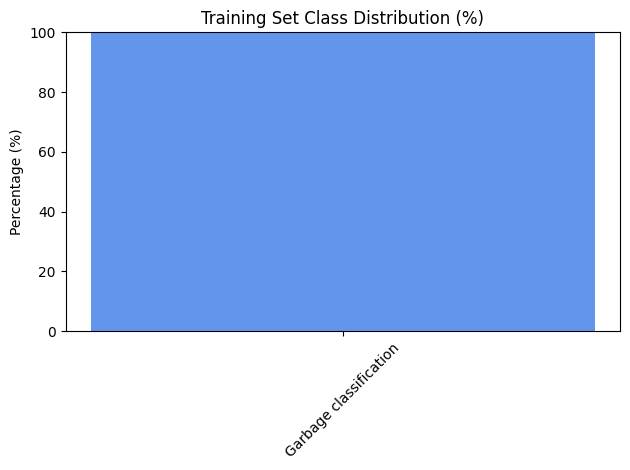

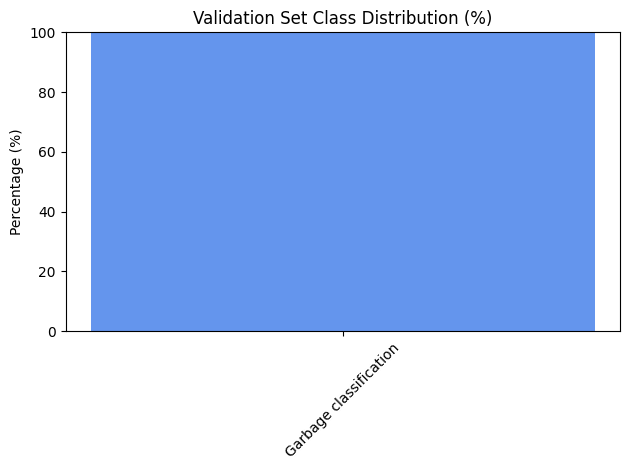

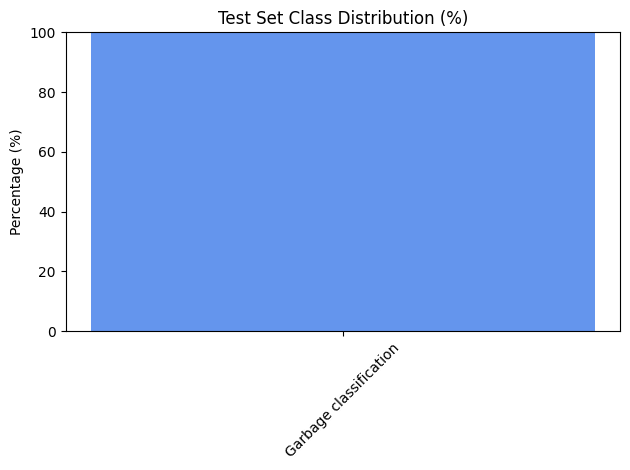

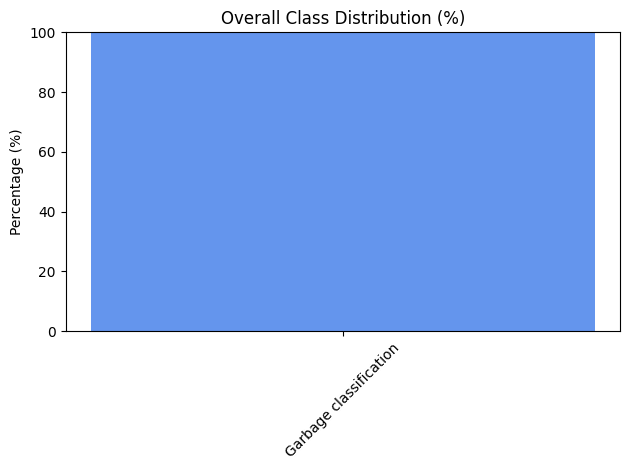

In [ ]:
# Show visualizations
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Count class occurrences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        if isinstance(label, np.ndarray):  # handle one-hot encoded case
            label = np.argmax(label)
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),  # use actual labels present in the data
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in zip(np.unique(all_labels), class_weights_array)}

In [ ]:
#✅ Optional: print results
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

Class Counts: {0: 2022}
Class Weights: {np.int32(0): np.float64(1.0)}


In [ ]:
#  Define data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [ ]:
#  Load the pretrained MobileNetV3Small model (without the top classification layer)
base_model = EfficientNetV2B2(include_top=False, input_shape=(124, 124, 3),include_preprocessing=True, weights='imagenet')


#  Freeze early layers (to retain general pretrained features)
base_model.trainable = True
for layer in base_model.layers[:100]:  # You can adjust this number
    layer.trainable = False

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#  Build the final model
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Change to your number of classes
])

In [ ]:
# ⚙️ Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)

In [ ]:
# Fix class_weights to reindex from 0
label_mapping = {label: idx for idx, label in enumerate(sorted(set(all_labels)))}
mapped_labels = [label_mapping[label] for label in all_labels]

from sklearn.utils.class_weight import compute_class_weight

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(label_mapping)),
    y=mapped_labels
)

class_weights = {i: w for i, w in enumerate(class_weights_array)}

In [ ]:
# 📝 Summary (optional but useful)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 4, 4, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,777,828 (33.48 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

In [ ]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 124, 124,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 124, 124,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 124, 124,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 62, 62,    │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 62, 62,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 62, 62,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 62, 62,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 62, 62,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 62, 62,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 62, 62,    │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 62, 62,    │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 62, 62,    │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 31, 31,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 31, 31,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 31, 31,    │          0 │ block2a_expand_b

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

Epoch 1/7
64/64 ━━━━━━━━━━━━━━━━━━━━ 231s 3s/step - accuracy: 0.3790 - loss: 1.6025 - val_accuracy: 0.9844 - val_loss: 0.3859
Epoch 2/7
64/64 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.9929 - loss: 0.2840 - val_accuracy: 1.0000 - val_loss: 0.0374
Epoch 3/7
64/64 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 1.0000 - loss: 0.0378 - val_accuracy: 1.0000 - val_loss: 0.0155
Epoch 4/7
64/64 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 1.0000 - loss: 0.0147 - val_accuracy: 1.0000 - val_loss: 0.0074
Epoch 5/7
64/64 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 1.0000 - loss: 0.0089 - val_accuracy: 1.0000 - val_loss: 0.0047
Epoch 6/7
64/64 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 7/7
64/64 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 1.0000 - val_loss: 0.0025


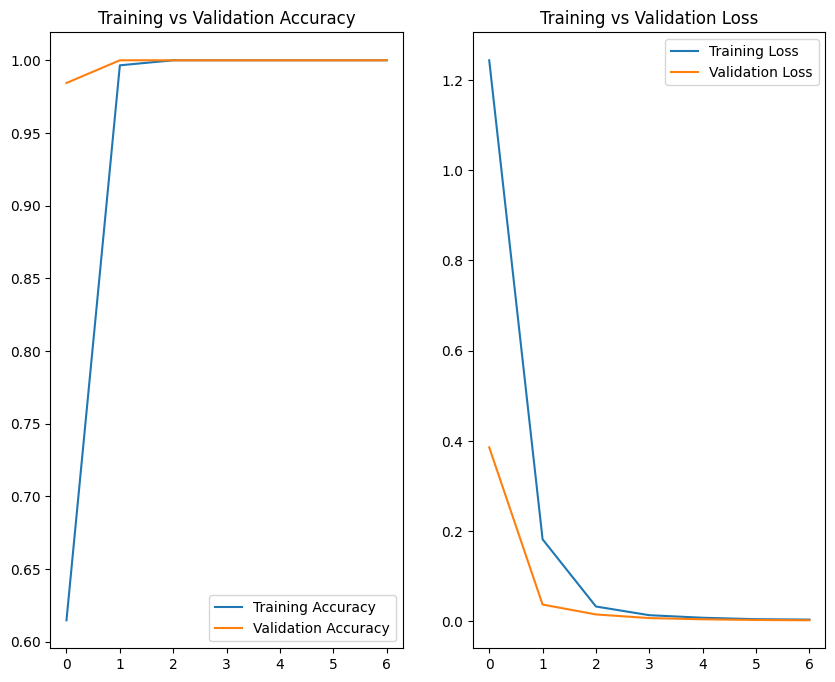

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=7
)

acc = history.history['accuracy']          # Extract training accuracy from history
val_acc = history.history['val_accuracy']  # Extract validation accuracy from history
loss = history.history['loss']             # Extract training loss from history
val_loss = history.history['val_loss']     # Extract validation loss from history

epochs_range = range(len(acc))             # Define range for epochs based on accuracy length

plt.figure(figsize=(10,8))                 # Set overall figure size for visualization

plt.subplot(1,2,1)                         # Create first subplot (1 row, 2 columns, position 1)
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Place legend in lower-right corner
plt.title('Training vs Validation Accuracy') # Add title for accuracy plot

plt.subplot(1,2,2)                         # Create second subplot (1 row, 2 columns, position 2)
plt.plot(epochs_range, loss, label='Training Loss')         # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')   # Plot validation loss
plt.legend(loc='upper right')              # Place legend in upper-right corner
plt.title('Training vs Validation Loss')   # Add title for loss plot

plt.show()                                 # Display the plots

In [ ]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 1.0000 - loss: 0.0015
Test accuracy is1.0000, Test loss is 0.0014


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Extract true labels from all batches in the test dataset
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)  # Convert Tensor labels to NumPy array and concatenate them

# Get predictions as probabilities from the model
y_pred_probs = model.predict(test_ds)  # Predict class probabilities for each sample in the test dataset

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # Select the class with the highest probability for each sample

# Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(y_true, y_pred)  # Generate confusion matrix comparing true labels to predicted labels

# Print metrics to assess model performance
print(cm)  # Display confusion matrix
print(classification_report(y_true, y_pred))  # Print precision, recall, and F1-score for each class

NameError: name 'test_ds' is not defined

In [ ]:
plt.figure(figsize=(10,8))  # Set figure size for better visualization

sns.heatmap(cm, annot=True, fmt='d',  # Create heatmap using confusion matrix
            xticklabels=class_names,  # Set class names for x-axis (predicted labels)
            yticklabels=class_names,  # Set class names for y-axis (true labels)
            cmap='Blues')  # Use a blue colormap for better contrast

plt.xlabel('Predicted')  # Label x-axis as Predicted classes
plt.ylabel('True')  # Label y-axis as True classes
plt.title('Confusion Matrix')  # Add title to the heatmap
plt.show()  # Display the plot

NameError: name 'cm' is not defined

<Figure size 1000x800 with 0 Axes>

In [ ]:
# Extract class names from the training dataset
class_names = train_ds.class_names

# Take one batch of images and labels from the test dataset for evaluation
for images, labels in test_ds_eval.take(1):

    # Generate predictions for the batch of images
    predictions = model.predict(images)

    # Get the predicted class index for each image
    pred_labels = tf.argmax(predictions, axis=1)

    # Loop through the first 8 images in the batch
    for i in range(8):
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert and display image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Show actual and predicted class
        plt.axis("off")  # Hide axes for better visualization
        plt.show()  # Display the image with title

In [ ]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Effiicientnetv2b2.keras')

# Load your Keras model
model = tf.keras.models.load_model('Effiicientnetv2b2.keras')